# Salon2 Lecture 2 - Feb 5, 2015

## 1 Python language review

Here are the topics we touched, with some weblinks to tutorials or discussions:

* [Containers](https://thenewcircle.com/static/bookshelf/python_fundamentals_tutorial/advanced_types_containers.html) (lists, tuples, dictionaries)
* [Tuples vs lists](http://www.diveintopython.net/native_data_types/tuples.html)
* [Comprehensions](http://python-3-patterns-idioms-test.readthedocs.org/en/latest/Comprehensions.html)
* [Variables vs names](http://nedbatchelder.com/text/names.html)

## 2 Choosing good third-party packages

Possible considerations:

* Use effort commensurate to need
* Start with googling
* Watch "external" signs of reliability:
    * Decent website
    * Documentation
    * Funding if any
    * Support resources
    * Updates/releases
    * Version number >= 1.0?
    * Reasonable dependencies
* Download/install, try tutorial
* What are the alternatives?
* When everything fails, write your own

## 3 Numpy

Python lists (and nested lists) are not usually suitable for mathematical work; they do not understand arithmetics natively, they are not efficient (because they require levels of [indirection](http://en.wikipedia.org/wiki/Indirection)), and they require looping in Python, which is again not efficient.

By contrast, working with mathematical vectors and arrays requires fast operations on large memory blocks that contain homogeneous types (all ints, doubles, etc.). This is also the memory layout that's expected by C/Fortran programs, so interacting with external legacy or performance codes requires this same "buffer" paradigm.

This is what's provided by [numpy](http://www.numpy.org), which is a building block and a basic infrastructure for most scientific applications in Python.

See [Johansson's numpy tutorial](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-2-Numpy.ipynb); also on [scipy](http://nbviewer.ipython.org/urls/raw.github.com/jrjohansson/scientific-python-lectures/master/Lecture-3-Scipy.ipynb), Python's "ecosystem" open-source scientific software, and on [matplotlib](http://nbviewer.ipython.org/urls/raw.github.com/jrjohansson/scientific-python-lectures/master/Lecture-4-Matplotlib.ipynb).

### 3.1 Game of life with numpy

* [Conway's Game of Life and its rules](http://en.wikipedia.org/wiki/Conway%27s_Game_of_Life)

We'll work in subdirectory 'lecture2-files'.

In [61]:
import os

In [62]:
os.chdir('lecture2-files')

Load a few more basic packages.

In [1]:
import numpy as np
import matplotlib.pyplot as pp
%matplotlib inline

In [2]:
import scipy

We'll represent the grid with a numpy array of integers. Let's start by initializing it randomly. `numpy.random.rand` yields reals in [0,1], so we round them to 0 (dead) or 1 (alive).

In [3]:
nsize = 32

In [4]:
init = np.floor(np.random.rand(nsize,nsize) + 0.5)

Or we could convert a boolean array (which will be True/False with 50% probability) to integers...

In [11]:
(np.random.rand(nsize,nsize) > 0.5) * 1

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 0]])

By the way, here's how you can count true elements in a boolean array:

In [12]:
np.sum(np.random.rand(nsize,nsize) > 0.5)

501

Now we'd like to plot the array. `imshow` from `matplotlib.pyplot` seems to work well.

In [13]:
def plotgrid(x):
    # turn off interpolation to get hard cell edges; put (0,0) at bottom left;
    # use a gray colormap that will yield black/white
    pp.imshow(x,interpolation='none',origin='bottom',cmap=pp.cm.gray)

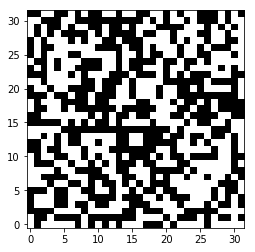

In [14]:
plotgrid(init)

Time to implement the evolution in the Game of Life; how to compute the number of neighbors? We could loop brute force, using modulo arithmetic to implement wrap-around boundary conditions...

In [15]:
def lifestep_brute(x):
    newx = x.copy()
    
    m, n = x.shape
    for i in range(m):
        for j in range(n):
            neighbors = (x[(i+1) % m,(j-1) % n] + x[(i+1) % m,j] + x[(i+1) % m,(j+1) % n] +
                         x[i,        (j-1) % n]                  + x[i,        (j+1) % n] +
                         x[(i-1) % m,(j-1) % n] + x[(i-1) % m,j] + x[(i-1) % m,(j+1) % n])
            
            if x[i,j] == 1 and (neighbors < 2 or neighbors > 3):
                newx[i,j] = 0
            elif x[i,j] == 0 and neighbors == 3:
                newx[i,j] = 1
    
    return newx

This works OK, although it's not especially fast...

In [16]:
# let's make a function to run some steps with a choice of "stepper" 
def runiter(stepper,iters=100,nsize=64):
    x = np.floor(np.random.rand(nsize,nsize) + 0.5)
    for i in range(iters):
        x = stepper(x)

In [17]:
%timeit runiter(lifestep_brute,100)

1.5 s ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can plot a few frames using `matplotlib.pyplot.subplot`, which works just like matlab's.

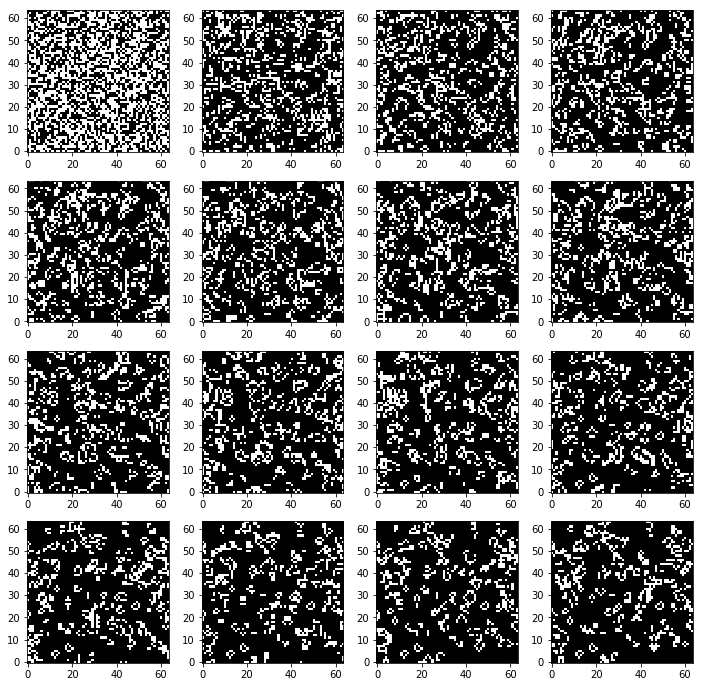

In [18]:
pp.figure(figsize=(12,12))
x = np.floor(np.random.rand(64,64) + 0.5)

for i in range(16):
    pp.subplot(4,4,i+1)
    plotgrid(x)

    x = lifestep_brute(x)

In `numpy`, it's always more efficient to work with full arrays; however in this case this means that we need to do something special on the boundaries to get the wraparound effect. That's a lot of special cases to write in our code (the four edges, plus the four corners, all require different indexing).

We could make an extended copy of the array by pasting the last column to the left of the first, the first column to the right of last, etc. Or, we look in the `numpy` manual and find the function `roll` that yields a rolled-with-wraparound copy of a matrix. (`numpy.lookfor`, and in this case `numpy.lookfor('shift')` is a good way to find these things!)

In [19]:
def lifestep_roll(x):
    newx = x.copy()
    
    neighbors = 0
    for di in [(1,1),(1,0),(1,-1),(0,1),(0,-1),(-1,1),(-1,0),(-1,-1)]:
        neighbors += np.roll(np.roll(x,di[0],axis=0),di[1],axis=1)
    
    # notice the numpy *fancy indexing* to work on selected items of an array
    # based on some conditions
    newx[(x == 1) & (neighbors < 2)] = 0
    newx[(x == 1) & (neighbors > 3)] = 0
    newx[(x == 0) & (neighbors == 3)] = 1    

    return newx

It's 50 times faster!

In [20]:
%timeit runiter(lifestep_roll,100)

34.5 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


...and somebody who's mathematically inclined may realize that the neighbor counting operation is a 2D convolution, which must certainly be implemented in one of these libraries. We do need to make sure to pass the right options to get back a matrix of the right size, and to impose the periodic boundary conditions.

In [7]:
import scipy.signal

kernel_conway = np.array([[1,1,1],[1,0,1],[1,1,1]])

def lifestep_conv(x):
    newx = x.copy()
    
    neighbors = scipy.signal.convolve2d(x,kernel_conway,boundary='wrap',mode='same')
    
    newx[(x == 1) & (neighbors < 2)] = 0
    newx[(x == 1) & (neighbors > 3)] = 0
    newx[(x == 0) & (neighbors == 3)] = 1    

    return newx

For this size of matrix, the timing is actually comparable to the rolling version.

In [23]:
%timeit runiter(lifestep_conv,100)

23.1 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Last, somebody who's *very* mathematically inclined may realize that the convolution can be performed efficiently with FFTs. It takes some trial and error to figure out some necessary adjustments.

In [21]:
import numpy.fft as npf

def fft_convolve2d(x,y,round=True):
    """2D convolution using FFT, adapted from Tristan Hearn's example."""
    
    fr  = npf.fft2(x)
    fr2 = npf.fft2(y,s=fr.shape)
    
    convolve = np.real(npf.ifft2(fr * fr2))

    # the result needs to be shifted around
    m, n = y.shape
    convolve = np.roll(convolve,-int((m-1)/2),axis=0)
    convolve = np.roll(convolve,-int((n-1)/2),axis=1)

    if round:
        return convolve.round()
    else:
        return convolve

In [19]:
def lifestep_fftconv(x):
    newx = x.copy()
    
    neighbors = fft_convolve2d(x,kernel_conway)
    
    newx[(x == 1) & (neighbors < 2)] = 0
    newx[(x == 1) & (neighbors > 3)] = 0
    newx[(x == 0) & (neighbors == 3)] = 1    

    return newx

This is slower!

In [26]:
%timeit runiter(lifestep_fftconv,100)

69.3 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We should really make an animation! `matplotlib` offers the tools to do so, but the interface is not the best. It requires that we make a figure, then provide a function to modify it for each frame. See for instance this [blog post](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial).

In [8]:
frames = []
x = np.floor(np.random.rand(256,256) + 0.5)

# we collect the frames in a list
for i in range(250):
    frames.append(x)
    x = lifestep_conv(x)

This will take a few seconds... it requires `ffmpeg` to be installed on the system. It's already available in the Binder installation.

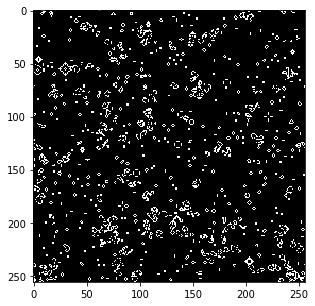

In [9]:
import matplotlib.animation as ma

# default resolution is 72 dpi
figure = pp.figure(figsize=(5,5))
image  = pp.imshow(frames[i],interpolation='none',cmap=pp.cm.gray)

# the animate function needs to change the elements of the figure,
# and return an iterable object containing the parts of the figure that have changed
def animate(i):
    image.set_array(frames[i])
    return [image]

# the API is not the best though...
anim = ma.FuncAnimation(figure,animate,frames=len(frames),
                        interval=20,blit=True)

anim.save('life.mp4',fps=30);

The output of this cell is just the last image, but we have written the movie to the file `life.mp4`. We can see it in the notebook with a little bit of iPython magic.

In [11]:
%%HTML
<video width="360" height="360" controls>
  <source src="life.mp4" type="video/mp4">
</video>

### 3.2 Homework (for the ambitious)

Modify our code to implement Stephan Rafler's *SmoothLife* floating-point generalization of the Game of Life. See his [paper](http://arxiv.org/abs/1111.1567).

In [12]:
x = np.linspace(0,5,200)

In [13]:
alpha = 0.2

def step(x,a):
    return 1/(1 + np.exp(-4*(x-a)/alpha))

def isinside(x,a,b):
    return step(x,a) * (1 - step(x,b))

# range of x is assumed [0,1]
def interp(x,a,b):
    return a * (1 - step(x,0.5)) + b * step(x,0.5)

def alive_conway(n,m):
    return isinside(n,interp(m,2.5,1.5),interp(m,3.5,3.5))

In [14]:
def kernels(nsize,r_in=7.0,r_out=21.0):
    ksize = nsize/2 + 1

    x = np.arange(0,ksize) - (ksize-1)/2
    y = np.arange(0,ksize) - (ksize-1)/2
    x, y = np.meshgrid(x,y)

    r = np.sqrt(x**2 + y**2)

    kernel_in  = 1 - step(r,r_in) 
    kernel_out = isinside(r,r_in,r_out)
    
    kernel_in /= np.sum(kernel_in)
    kernel_out /= np.sum(kernel_out)
    
    return kernel_in, kernel_out

In [22]:
conf = np.random.rand(128,128)

kri, kro = kernels(128)

def alive_smooth(n,m):
    return isinside(n,interp(m,0.278,0.267),interp(m,0.365,0.445))

def step_discrete(conf):
    n = scipy.signal.convolve2d(conf,kri,boundary='wrap',mode='same')
    m = scipy.signal.convolve2d(conf,kro,boundary='wrap',mode='same')
    
    return alive_smooth(n,m)

def step_continuous(conf,dt=0.1,fft=True):
    if fft:
        n = fft_convolve2d(conf,kri,round=False)
        m = fft_convolve2d(conf,kro,round=False)
    else:
        n = scipy.signal.convolve2d(conf,kri,boundary='wrap',mode='same')
        m = scipy.signal.convolve2d(conf,kro,boundary='wrap',mode='same')
    
    return conf + dt * (2*alive_smooth(n,m) - 1)

Hmm... doesn't seem to be working so well... the paper has ra = 21, b1 = 0.278, b2 = 0.365, d1 =
0.267, d2 = 0.445, αn = 0.028, αm = 0.147. Unclear about application of alphan and alpham.

In [23]:
conf = np.zeros((128,128),'d')

conf[20:30,20:30] = 1.0

In [24]:
for i in range(1000):
    conf = step_continuous(conf)

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


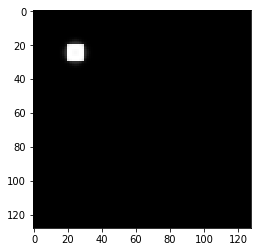

In [25]:
pp.imshow(conf,interpolation='none',cmap=pp.cm.gray)

## 4 h5py (for the HDF file format)

We went over this very quickly in class, so I will just paste in the code from last year. If you don't have h5py, try `conda` or `pip`.

It's HDF5, a "data model, library, and file format", "portable and extensible", that "supports an unlimited variety of datatypes, and is designed for flexible and efficient I/O and for high volume and complex data". h5py is _the_ Python library to read/write HDF5; it can be used to get efficient numpy views on very large datafiles.

* http://www.hdfgroup.org
* http://www.h5py.org

#### 4.1 Playing with LIGO data

LIGO has recently released its flagship "S5" data: https://losc.ligo.org

Following the tracks of the webinar at https://dcc.ligo.org/public/0113/G1400509/004/losc_webinar.pdf. We'll look for "H1" data starting at time 843894784 and ending at 843898880.

In [26]:
!wget https://losc.ligo.org/archive/data/S5/843055104/H-H1_LOSC_4_V1-843894784-4096.hdf5

--2018-02-20 13:44:18--  https://losc.ligo.org/archive/data/S5/843055104/H-H1_LOSC_4_V1-843894784-4096.hdf5
Resolving losc.ligo.org (losc.ligo.org)... 131.215.125.132
Connecting to losc.ligo.org (losc.ligo.org)|131.215.125.132|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: https://losc.ligo.org/archive/data/S5/843055104/H-H1_LOSC_4_V1-843894784-4096.hdf5/ [following]
--2018-02-20 13:44:19--  https://losc.ligo.org/archive/data/S5/843055104/H-H1_LOSC_4_V1-843894784-4096.hdf5/
Reusing existing connection to losc.ligo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 128652813 (123M) [application/x-hdf]
Saving to: ‘H-H1_LOSC_4_V1-843894784-4096.hdf5’

H-H1_LOSC_4_V1-8438 100%[===================>] 122.69M  10.0MB/s    in 15s     

2018-02-20 13:44:33 (8.41 MB/s) - ‘H-H1_LOSC_4_V1-843894784-4096.hdf5’ saved [128652813/128652813]



In [28]:
import h5py

/srv/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [29]:
data = h5py.File('H-H1_LOSC_4_V1-843894784-4096.hdf5','r')

In [30]:
data

<HDF5 file "H-H1_LOSC_4_V1-843894784-4096.hdf5" (mode r)>

HDF5 file objects have a tree-like structure, and in the Python API tree nodes at every level behave as Python dictionaries. Remember the Python `dict` methods, which return [iterators](http://pymbook.readthedocs.org/en/latest/igd.html) (technically, *dictionary views*) that you can loop over:

* `keys()`, yielding the keys indexing the dictionary,
* `values()`, yielding the values in the same order,
* `items()`, yielding (key,value) pairs.

If you need a proper list of any of these, you can always feed the iterators to the `list()` constructor.

In [31]:
list(data.items())

[('meta', <HDF5 group "/meta" (8 members)>),
 ('quality', <HDF5 group "/quality" (3 members)>),
 ('strain', <HDF5 group "/strain" (1 members)>)]

h5py implements the somewhat peculiar `visit` method that walks down the HDF tree in full.

In [32]:
def printname(name):
    print("%-35s %s" % (name,data[name]))

In [33]:
data.visit(printname)

meta                                <HDF5 group "/meta" (8 members)>
meta/Description                    <HDF5 dataset "Description": shape (), type "|S33">
meta/DescriptionURL                 <HDF5 dataset "DescriptionURL": shape (), type "|S21">
meta/Detector                       <HDF5 dataset "Detector": shape (), type "|S2">
meta/Duration                       <HDF5 dataset "Duration": shape (), type "<i8">
meta/GPSstart                       <HDF5 dataset "GPSstart": shape (), type "<i8">
meta/Observatory                    <HDF5 dataset "Observatory": shape (), type "|S1">
meta/Type                           <HDF5 dataset "Type": shape (), type "|S16">
meta/UTCstart                       <HDF5 dataset "UTCstart": shape (), type "|S19">
quality                             <HDF5 group "/quality" (3 members)>
quality/detail                      <HDF5 group "/quality/detail" (0 members)>
quality/injections                  <HDF5 group "/quality/injections" (3 members)>
quality/injec

There's useful information in "`meta`":

In [34]:
data['meta/GPSstart'].value, data['meta/Duration'].value

(843894784, 4096)

"`strain`" seems to be the main structure containing data...

In [35]:
strain = data['strain/Strain']

...which looks like a numpy array...

In [36]:
type(strain.value), strain.value

(numpy.ndarray, array([ 2.86956749e-17,  3.12350546e-17,  3.37783919e-17, ...,
        -1.12435587e-16, -1.08725030e-16, -1.04909780e-16]))

But it has also attributes:

In [37]:
list(strain.attrs.items())

[('Npoints', 16777216),
 ('Xunits', b'second'),
 ('Xlabel', b'GPS time'),
 ('Xspacing', 0.000244140625),
 ('Xstart', 843894784),
 ('Yunits', b''),
 ('Ylabel', b'Strain')]

We use these to make an array of timestamps.

In [38]:
tstart = strain.attrs['Xstart']
dt     = strain.attrs['Xspacing']
tend   = tstart + strain.attrs['Npoints'] * dt

# according to C convention, "tend" is not actually included in this array
ts = np.arange(tstart,tend,dt)

In [39]:
len(ts), len(strain.value)

(16777216, 16777216)

Let's plot the very beginning of the data.

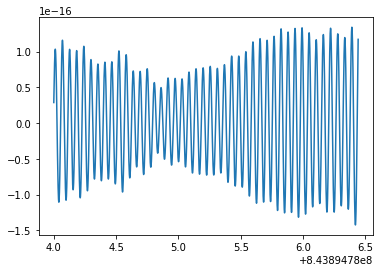

In [40]:
pp.plot(ts[:10000],
        strain.value[:10000])

There's also "`quality`", which (we learn from https://losc.ligo.org/archive/dataset/S5) describes the quality of the data with a 1-Hz bitmask array.

In [41]:
quality = data['quality/simple']

In [42]:
list(quality.items())

[('DQDescriptions', <HDF5 dataset "DQDescriptions": shape (18,), type "|S71">),
 ('DQShortnames', <HDF5 dataset "DQShortnames": shape (18,), type "|S15">),
 ('DQmask', <HDF5 dataset "DQmask": shape (4096,), type "<u4">)]

These are the meanings of the bits:

In [43]:
for bit,(name,desc) in enumerate(zip(quality['DQShortnames'].value,quality['DQDescriptions'].value)):
    print('%2d %-16s %s' % (bit, name.decode(), desc.decode()))

 0 DATA             Science data present
 1 CBCHIGH_CAT1     Category-1 checks passed for CBC high-mass search
 2 CBCHIGH_CAT2     Category-2 and 1 checks passed for CBC high-mass search
 3 CBCHIGH_CAT3     Category-3 and 2 and 1 checks passed for CBC high-mass search
 4 CBCHIGH_CAT4     Category-4,3,2,1 checks passed for CBC high-mass search
 5 CBCLOW_CAT1      Category-1 checks passed for CBC low-mass search
 6 CBCLOW_CAT2      Category-2 and 1 checks passed for CBC low-mass search
 7 CBCLOW_CAT3      Category-3 and 2 and 1 checks passed for CBC low-mass search
 8 CBCLOW_CAT4      Category-4, veto active for CBC low-mass search
 9 BURST_CAT1       Category-1 checks passed for burst search
10 BURST_CAT2       Category-2 and 1 checks passed for burst search
11 BURST_CAT3       Category-3 and 2 and 1 checks passed for burst search
12 BURST_CAT2E      Category-2E and 1 subsecond-event checks passed for burst search
13 BURST_CAT3E      Category-3E, 2E, 1 subsecond-event checks passed for 

A note on the `decode`, which is needed in Python 3 to avoid displaying strings as `b'...'`. The issue is that in Python 3 native strings are [unicode](https://docs.python.org/3/howto/unicode.html), but the LOSC files contain simple ASCII strings (where each character is 8 bits), which in Python 3 correspond to `bytes` object, not quite a string. The `bytes` method `decode()`, with the implied argument `'UTF-8'`, uses a unicode encoding to make a unicode string out of a sequence of bytes. Its inverse is `encode()`.

Back to LIGO. How much data at "CBCHIGH" categories 1 through 4? CBCHIGH denotes the search for high-mass binary inspirals. As for the categories,

* CAT1 = data that passes basic quality checks
* CAT2 = data that does not have obvious corruption or noisy features with clear correlations with instrument events and failure modes
* CAT3 = data that does not have even less obvious noisy features with unclear instrumental associations
* CAT4 = data that has been cleaned of glitchy features that result in excess triggers

A LIGO search would use CAT2 data; an upper-limit analysis would use CAT3.

In [44]:
dqarray = quality['DQmask'].value

for cbchigh_cat in [1,2,3,4]:
    bitmask = 1 << cbchigh_cat
    print("%s seconds at CAT %d" % (sum(dqarray & bitmask > 0),cbchigh_cat))

4096 seconds at CAT 1
4029 seconds at CAT 2
3391 seconds at CAT 3
3391 seconds at CAT 4


We are going to work with CAT2 data. Let's plot which data is CAT2 in "raster" fashion, reshaping a vector to a 2D matrix. We'll use `matplotlib.pyplot.matshow` the latter. We want a discrete rather than continuous colormap (i.e., 1 = red, 2 = yellow, 3 = green, 4 = blue). Some quick googling shows that this can be achieved with `ListedColormap` and `BoundaryNorm`.

In [45]:
dqplot = np.zeros(dqarray.shape)

for cbchigh_cat in [1,2,3,4]:
    bitmask = 1 << cbchigh_cat
    dqplot[dqarray & bitmask > 0] = cbchigh_cat

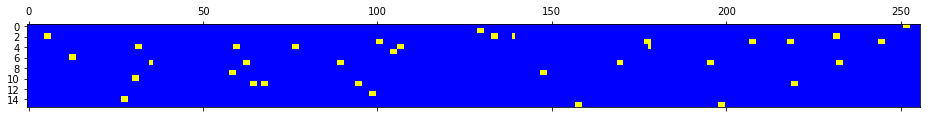

In [46]:
import matplotlib.colors as mpc

cmap = mpc.ListedColormap(['red','yellow','green','blue'])
norm = mpc.BoundaryNorm([0,1,2,3],cmap.N)
    
pp.matshow(dqplot.reshape((16,256)),cmap=cmap,norm=norm,aspect=1.5);

We use numpy _masked arrays_ to obtain the segments of CAT2 data.
* http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html

In [47]:
dq2 = (dqarray & (1 << 2)) > 0

masked = np.ma.masked_array(np.zeros(4096),~dq2)
segs = np.ma.flatnotmasked_contiguous(masked)
print(segs)

[slice(0, 251, None), slice(253, 385, None), slice(387, 517, None), slice(519, 645, None), slice(647, 651, None), slice(652, 743, None), slice(745, 868, None), slice(870, 945, None), slice(947, 975, None), slice(977, 986, None), slice(988, 1012, None), slice(1014, 1055, None), slice(1057, 1083, None), slice(1085, 1100, None), slice(1102, 1130, None), slice(1132, 1202, None), slice(1203, 1384, None), slice(1386, 1548, None), slice(1550, 1827, None), slice(1828, 1854, None), slice(1856, 1881, None), slice(1883, 1961, None), slice(1963, 1987, None), slice(1989, 2024, None), slice(2026, 2362, None), slice(2364, 2451, None), slice(2453, 2590, None), slice(2592, 2880, None), slice(2882, 2883, None), slice(2885, 2910, None), slice(2912, 3035, None), slice(3037, 3426, None), slice(3428, 3611, None), slice(3613, 3997, None), slice(3999, 4038, None), slice(4040, 4096, None)]


This will get us the strain data for segment `n`.

In [48]:
def segdata(n):
    start, end = segs[n].start * 4096, segs[n].stop * 4096
    
    return ts[start:end], strain.value[start:end]

Let's look at the PSD for the first few segment, using `psd` from `matplotlib.mlab`.

In [49]:
import matplotlib.mlab as mp

In [50]:
def plotpsd(i):
    segt, segd = segdata(i)
    psd, freqs = mp.psd(segd,NFFT=2048,Fs=1.0/dt)

    pp.loglog(freqs[1:],np.sqrt(psd[1:]))
    pp.xlabel('$f/\mathrm{Hz}$'); pp.ylabel('$S(f)/\mathrm{Hz}^{1/2}$')
    pp.axis([10,1000,1e-24,1e-14]);
    pp.title('t = [%s,%s]' % (segt[0],segt[-1]))

In [51]:
print(len(segs))

36


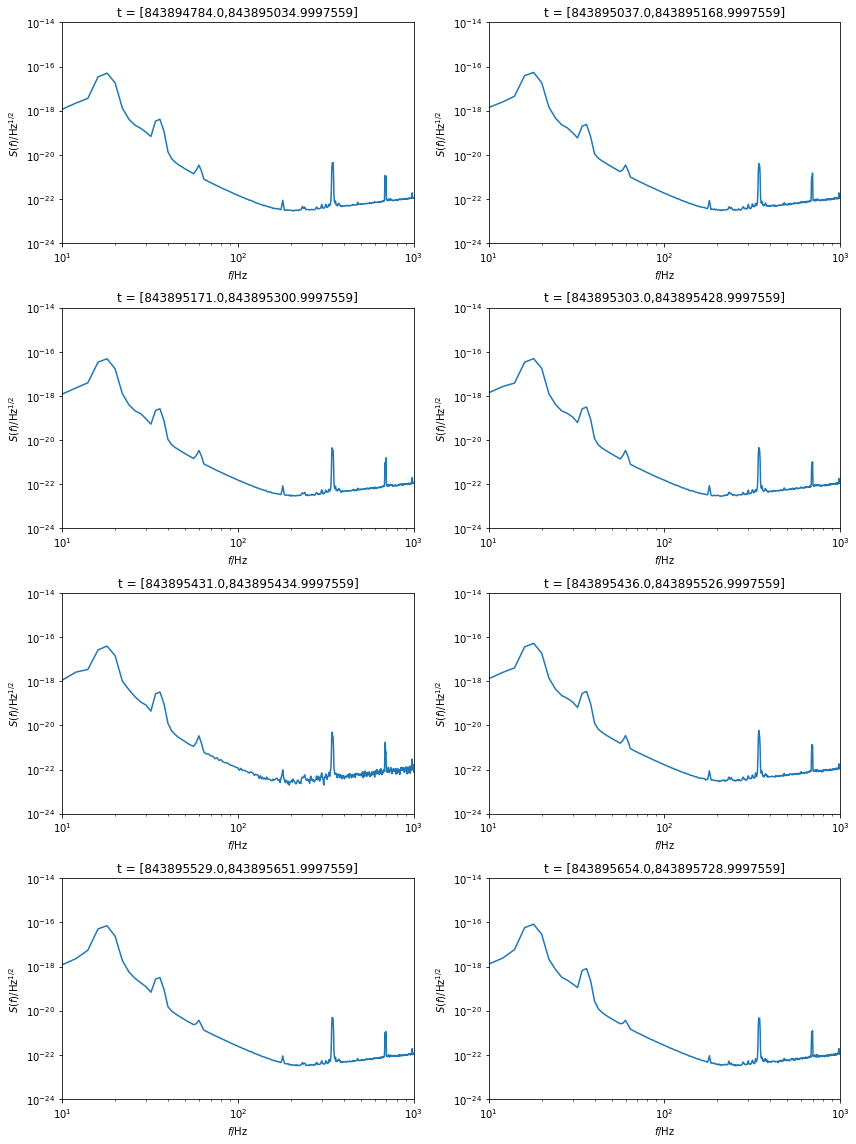

In [52]:
pp.figure(figsize=(12,16))

for s in range(8):
    pp.subplot(4,2,s+1)
    plotpsd(s)

pp.tight_layout()

To see if something goes "ping", we obtain a spectrogram using `matplotlib.mlab.specgram`. We examing segments of 4096 points = 1 sec.

We pick a prettier colormap than the default at http://matplotlib.org/examples/color/colormaps_reference.html

In [53]:
def plotspec(i):
    segt, segd = segdata(i)
    pxx, freqs, t = mp.specgram(segd,NFFT=4096,Fs=1.0/dt)

    # normalize each frequency row by its median (effectively to whiten data) 
    pxx = np.array([row / np.median(row) for row in pxx])
    
    pp.pcolormesh(t,freqs,np.log10(pxx),cmap=pp.get_cmap('Oranges'))
    pp.xlabel('$t/\mathrm{s}$'); pp.ylabel('$S(f)/\mathrm{Hz}^{1/2}$')
    pp.axis([0,t[-1],freqs[0],freqs[-1]])
    pp.title('t = [%s,%s]' % (segt[0],segt[-1]))

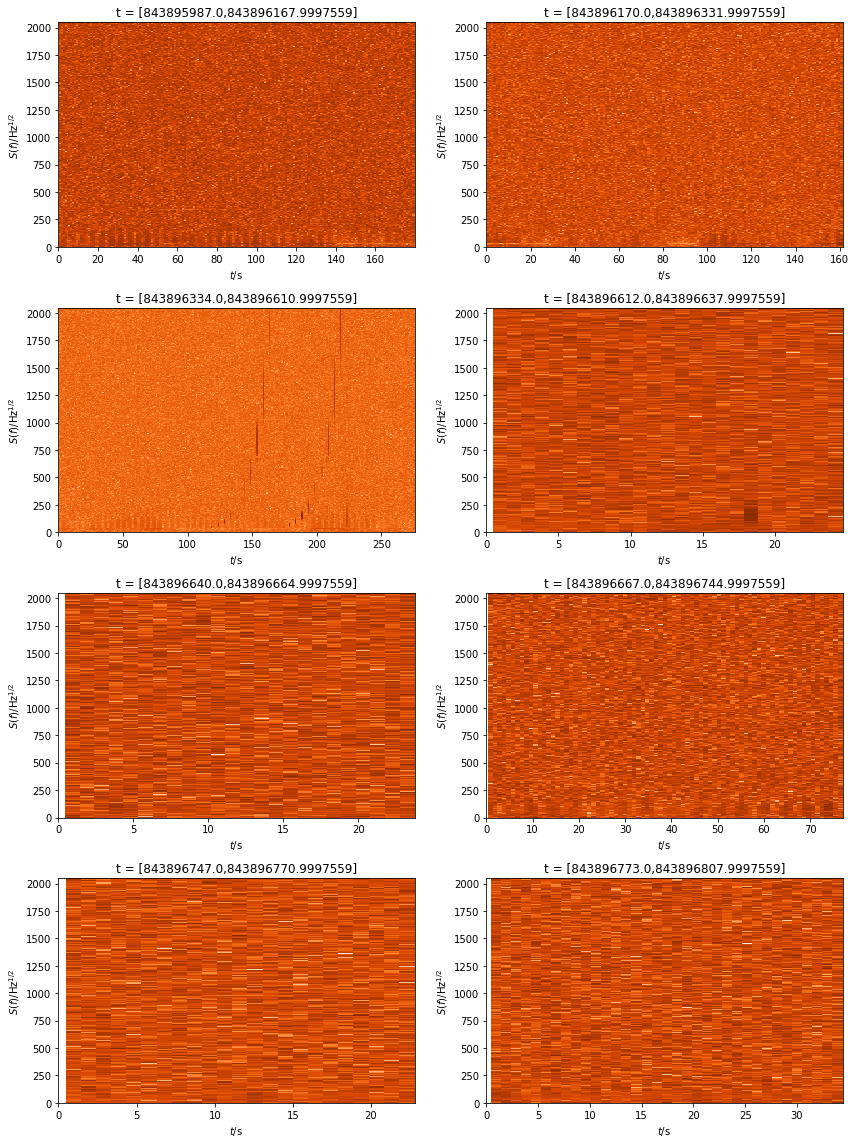

In [54]:
pp.figure(figsize=(12,16))

for s in range(16,24):
    pp.subplot(4,2,s-16+1)
    plotspec(s)

pp.tight_layout()

Ta-dah! There's something going on in segment 18, between GPS times...

In [55]:
t0, t1 = segdata(18)[0][0], segdata(18)[0][-1]
print(t0,t1)

843896334.0 843896610.9997559


So we download a list of injections from https://losc.ligo.org/s/injections/burst/H1_cleanlog_burst.txt...

In [56]:
!wget https://losc.ligo.org/s/injections/burst/H1_cleanlog_burst.txt

--2018-02-20 13:46:59--  https://losc.ligo.org/s/injections/burst/H1_cleanlog_burst.txt
Resolving losc.ligo.org (losc.ligo.org)... 131.215.125.132
Connecting to losc.ligo.org (losc.ligo.org)|131.215.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1487086 (1.4M) [text/plain]
Saving to: ‘H1_cleanlog_burst.txt’

H1_cleanlog_burst.t 100%[===================>]   1.42M  4.28MB/s    in 0.3s    

2018-02-20 13:46:59 (4.28 MB/s) - ‘H1_cleanlog_burst.txt’ saved [1487086/1487086]



In [57]:
!head -140 H1_cleanlog_burst.txt

# GPS  IFO  Waveform  Amp_factor  Log  Exp_SNR  Rec_SNR 
816055501.5   H1   wfsg2000Q9          1     Successful-                   1.0   1.8   
816055512.5   H1   wfsg235Q9           1     Successful-                   19.4  20.4  
816055523.5   H1   wfsg235Q9t1         1     Successful-                   19.4  19.3  
816077222.5   H1   wfga0010t1          0.2   Successful-                   2.8   3.2   
816077233.4   H1   wfga0010t2          0.2   Successful-                   2.8   3.3   
816077244.8   H1   wfga0010t3          0.2   Successful-                   2.8   2.9   
816087882.5   H1   wfga0010t1          0.2   Successful-                   2.8   2.6   
816087893.4   H1   wfga0010t2          0.2   Successful-                   2.8   3.2   
816087904.8   H1   wfga0010t3          0.2   Successful-                   2.8   2.9   
816155194.5   H1   wfga0010t1          0.2   Successful-                   2.8   3.4   
816155205.4   H1   wfga0010t2          0.2   Successful-       

Make a dictionary of injections indexed by their recorded time.

In [58]:
injections = {float(line.split()[0]): line for line in open('H1_cleanlog_burst.txt','r') if line[0] != '#'}

See if there are any in our window?

In [59]:
for t,line in injections.items():
    if (t0 < t < t1):
        print(line,end='')

843896452.5   H1   wfsg50Q9            48    Successful-                   55.2  53.2  
843896457.5   H1   wfsg70Q9            16    Successful-                   70.1  68.3  
843896462.5   H1   wfsg100Q9           6.4   Successful-                   88.7  86.7  
843896467.5   H1   wfsg153Q9           3.2   Successful-                   84.5  80.6  
843896472.5   H1   wfsg235Q9           3.2   Successful-                   72.8  67.2  
843896477.5   H1   wfsg393Q9           6.4   Successful-                   90.5  99.3  
843896482.5   H1   wfsg554Q9           8     Successful-                   88.7  82.9  
843896487.5   H1   wfsg850Q9           11.2  Successful-                   82.5  75.8  
843896492.5   H1   wfsg1304Q9          12.8  Successful-                   61.4  59.7  
843896497.5   H1   wfsg2000Q9          19.2  Successful-                   20.2  35.6  
843896502.5   H1   wfsg3068Q9          7.2   Successful-                   0.0   1.9   
843896507.5   H1   wfsg50Q9     

Plot them on top of the spectrogram, with their nominal frequency (which must be the 3-4 digits in the string that begins `wfsg`... `sg` stands for sine-Gaussian, a simple burst/wavelet).

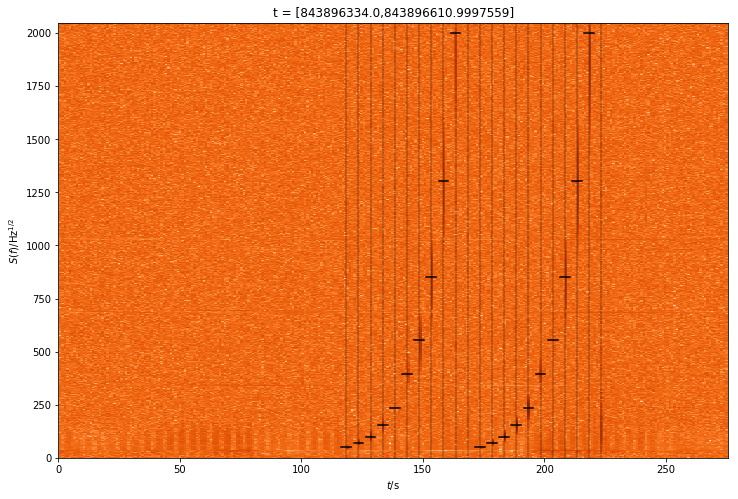

In [60]:
pp.figure(figsize=(12,8))

plotspec(18)

for t,line in injections.items():
    if (t0 < t < t1):
        pp.plot([t - t0,t - t0],[0,2048],'k',alpha=0.25)
        freq = float(line.split()[2][4:-2])
        pp.plot([t - t0 - 2,t - t0 + 2],[freq,freq],'k')

Oh yes!